# Averaging on Stiefel manifold

**QR-decomposition-based retraction and lifting maps**

Compute Riemannian mean on St(p, n) by applying retraction to the arithmetic average of the lifted points from a manifold to a tangent space.

Based on:  

_Empirical Arithmetic Averaging Over the Compact Stiefel Manifold_  
Kaneko, Tetsuya, Simone G. O. Fiori and Toshihisa Tanaka  
IEEE Transactions on Signal Processing 61 (2013): 883-894

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from numpy.linalg import qr, inv, solve, det

## Create data

Create an element of St(2, 3), 2-dimensional orthonormal frame in $\mathbb{R}^3$

In [26]:
Frame = np.array([[1, 0, 0], [0, 1, 0]]).T
Frame.shape

(3, 2)

Create $N$ elements of SO(3), special orhogonal group of rotation matrices, to rotate St(2, 3) along Z-axis by $N$ degrees by each rotation matrix

In [27]:
N = 61
SO = np.zeros((N, 3, 3))

for i, phi in enumerate(range(0, N)):
    phi = (phi + 1) / 360 * 2 * np.pi
    SO[i] = np.array([
        [np.cos(phi), -np.sin(phi), 0],
        [np.sin(phi), np.cos(phi), 0],
        [0, 0, 1]
    ])

Create $N$ elements of St(2, 3) by applying rotation transform

In [28]:
Frame_rot = np.zeros((N, Frame.shape[0], Frame.shape[1]))

for i, so in enumerate(SO):
    Frame_rot[i] = so.dot(Frame)
    
sought_for_mean_idx = int(Frame_rot.shape[0] / 2)
    
Frame_rot.shape

(61, 3, 2)

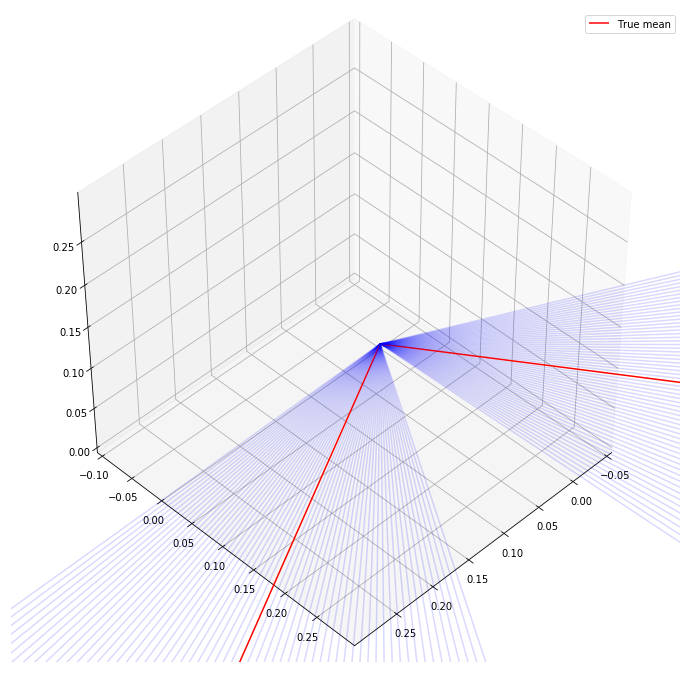

In [67]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

origin = [0,0,0]

for i, frame_rot in enumerate(Frame_rot):
    X, Y, Z = zip(origin, origin) 
    U, V, W = zip(frame_rot.T[0], frame_rot.T[1])
    c = "blue"
    alpha = 0.15
    label = None
    if i == sought_for_mean_idx:
        c = "red"
        alpha = 1
        label = "True mean"
    ax.quiver(X,Y,Z,U,V,W, color=c, alpha=alpha, arrow_length_ratio=0.01, label=label)

ax.set_xlim([-0.05,0.3])
ax.set_ylim([-0.1,0.3])
ax.set_zlim([0,0.3])
ax.view_init(45, 45)
ax.legend()

plt.show()

## Mean, retraction and lifting maps

In [51]:
def mean(X, Qs):
    V = []
    for i, Q in enumerate(Qs):
        try:
            v = lifting(X, Q)
            V.append(v)
            #####print("V=", V)
        except Exception as error:
            pass
            print("Q does not belong to the domain of the lifting map P_X^{-1}, because of", error)
            
    if len(V) <=0:
        raise Exception("V is empty")
            
    V = np.array(V)
    #####print(V.shape[0])
    
    V = np.mean(V, axis=0)

    X_mean = retraction(X, V)
    
    X_mean[:,0] = - X_mean[:,0]

    return X_mean

def retraction(X, V):
    Q, R = qr(X + V)
    return Q

def lifting(X, Q):
    
    p, n = X.shape
    
    R = np.zeros((n, n))
    r = []
    
    M = X.T.dot(Q)
    
    # construct r_0
    r.append(make_r(0, M))
        
    for i in range(1, n):
        #####print("i=", i)
        
        M_i = make_minor(i, M) # get principal minor
        if (det(M_i) != 0):
            b_i = make_b(i, M, r)
            r_i = inv(M_i).dot(b_i)
            
            if r_i[i] <= 0:
                raise Exception("(r_i)_i <= 0")
            else:
                r.append(r_i)
        else:
            raise Exception("det(M_i) == 0, not invertible")
    
    for i, item in enumerate(r):
        R[:len(item),i] = np.array(item)
        
    return Q.dot(R) - X

def make_minor(i, M):
        return M[:i+1,:i+1]

def make_r(i, M):
    if i == 0:
        #####print("i==0")
        if (M[0,0] > 0):
            return np.array([1 / M[0,0]])
        else:
            raise Exception("M[0,0] <= 0")
    else:
        return M[:i+1,i]

def make_b(i, M, r):

    b = np.ones(i+1)

    for j in range(i):
        #####print("j=", j)
        #####print(M[i,:j+1])
        b[j] = -M[i,:j+1].dot(r[j])

    #####print("b=", b)

    return b

## Compute mean

Set $X$ as initial sought-for-mean frame, with desired offset from true mean.  
Set $Q$ by $N-1$ other frames

In [68]:
offset = 10
X = Frame_rot[sought_for_mean_idx - offset]
Q = np.concatenate((Frame_rot[:sought_for_mean_idx], Frame_rot[sought_for_mean_idx+1:]))

Run fixed-point algorithm until convergence

In [69]:
i = 0
tol = 1e-6
converged = False

X_mean = np.copy(X)

while not converged:
    i += 1
    X_mean_prev = np.copy(X_mean)
    
    X_mean = mean(X_mean, Q)
    
    if np.linalg.norm(X_mean - X_mean_prev) <= tol:
        converged = True
        print("Converged in {} iterations".format(i))
    
X_mean

Converged in 7 iterations


array([[ 0.85716728, -0.5150381 ],
       [ 0.5150381 ,  0.85716728],
       [ 0.        , -0.        ]])

True mean

In [70]:
Frame_rot[sought_for_mean_idx]

array([[ 0.8571673 , -0.51503807],
       [ 0.51503807,  0.8571673 ],
       [ 0.        ,  0.        ]])

Norm of the difference of computed mean with true mean

In [71]:
np.linalg.norm(X_mean - Frame_rot[sought_for_mean_idx])

4.366839702409789e-08

## Plot computed mean

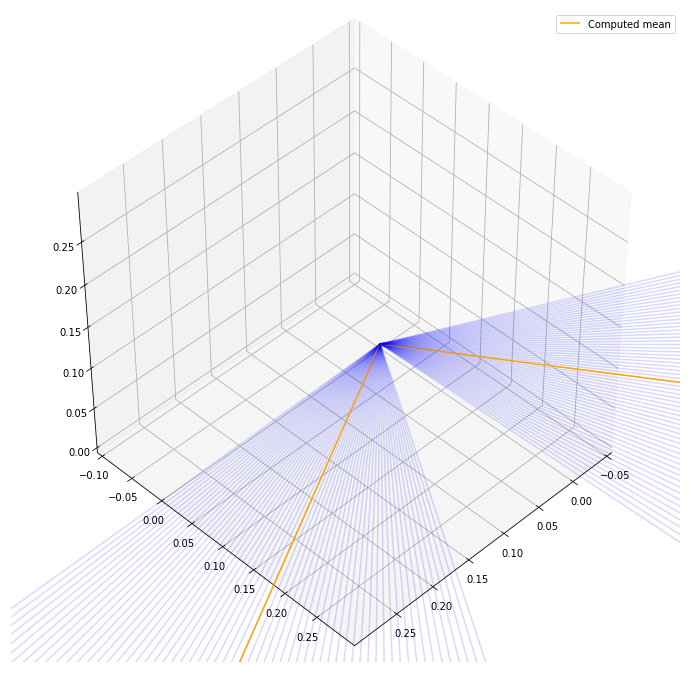

In [72]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

origin = [0,0,0]

for i, frame_rot in enumerate(Frame_rot):
    X, Y, Z = zip(origin, origin) 
    U, V, W = zip(frame_rot.T[0], frame_rot.T[1])
    c = "blue"
    alpha = 0.15
    ax.quiver(X,Y,Z,U,V,W, color=c, alpha=alpha, arrow_length_ratio=0.01)

X, Y, Z = zip(origin, origin) 
U, V, W = zip(X_mean.T[0], X_mean.T[1])
ax.quiver(X,Y,Z,U,V,W, color="orange", alpha=1, arrow_length_ratio=0.01, label='Computed mean')

ax.set_xlim([-0.05,0.3])
ax.set_ylim([-0.1,0.3])
ax.set_zlim([0,0.3])
ax.view_init(45, 45)
ax.legend()

plt.show()